Epoch 1/20
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 61s 13ms/step - accuracy: 0.1379 - loss: 5.5595 - val_accuracy: 0.8720 - val_loss: 1.9530 - learning_rate: 3.0000e-04
Epoch 2/20
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - accuracy: 0.6667 - loss: 2.4140 - val_accuracy: 0.9807 - val_loss: 0.1036 - learning_rate: 3.0000e-04
Epoch 3/20
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - accuracy: 0.9476 - loss: 0.5697 - val_accuracy: 0.9839 - val_loss: 0.0565 - learning_rate: 3.0000e-04
Epoch 4/20
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.9680 - loss: 0.2502 - val_accuracy: 0.9868 - val_loss: 0.0545 - learning_rate: 3.0000e-04
Epoch 5/20
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - accuracy: 0.9666 - loss: 0.1978 - val_accuracy: 0.9891 - val_loss: 0.0515 - learning_rate: 3.0000e-04
Epoch 6/20
4399/4399 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.9734 - loss: 0.1502 - val_accuracy: 0.9893 - val_loss: 0.0472 - learning_rate: 3.0000e-04
Epoch 7/20
4399/4399 ━━━━━━━━━━━━━━━━━━━

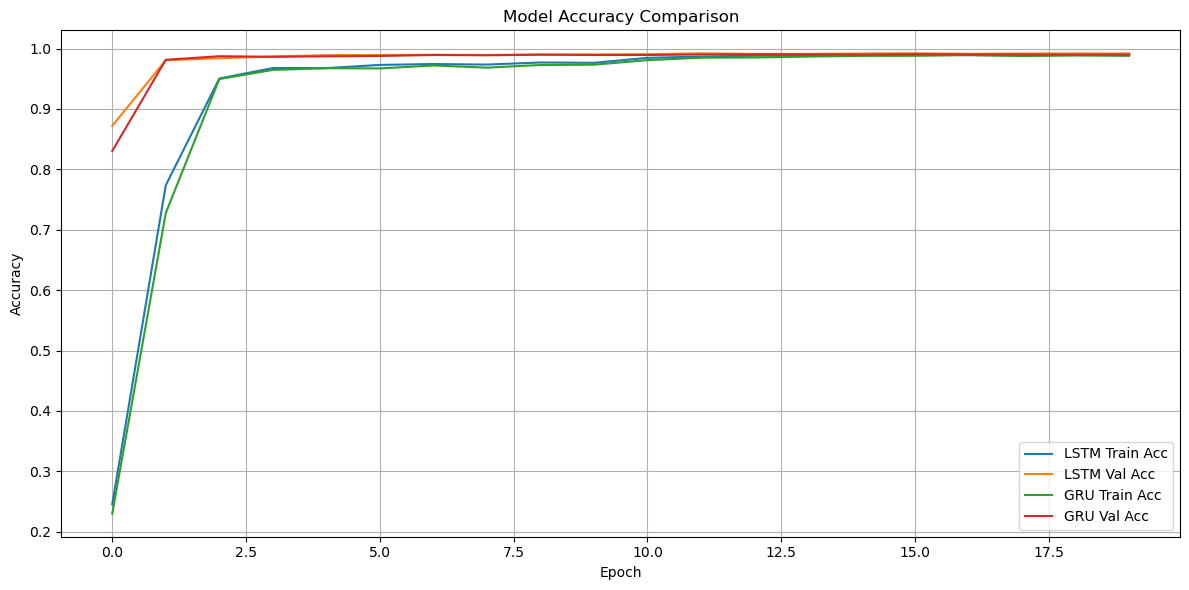

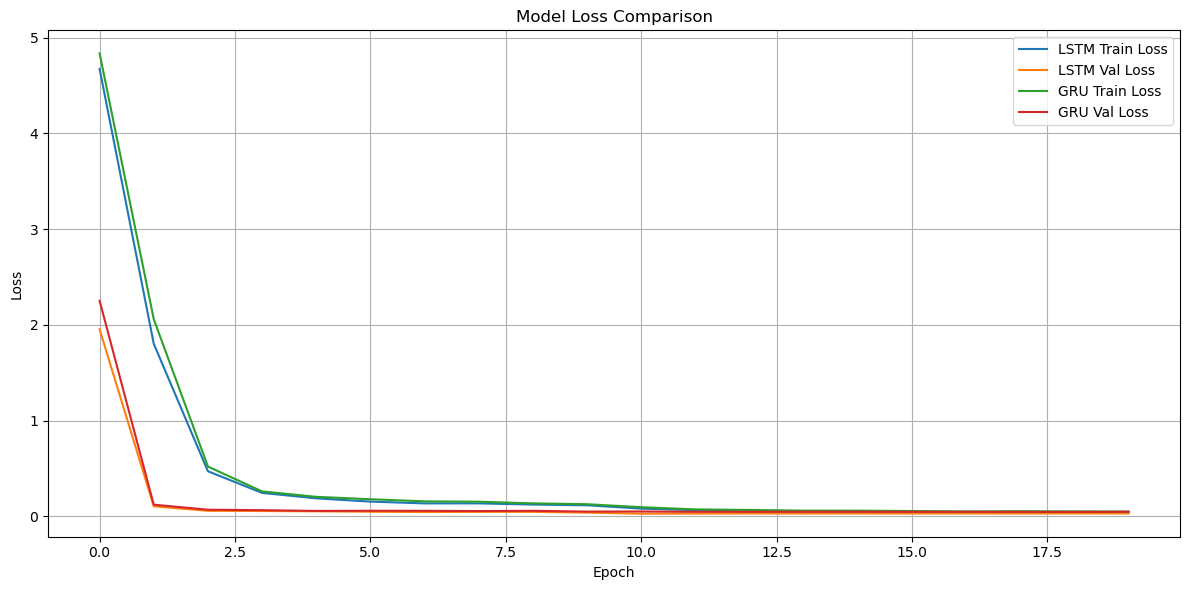

In [4]:
# train_lstm_gru.py
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import pickle
import os
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

is_voila = os.environ.get("VOILA_RUN_BY_PROXY") == "1"

with open("intents_1000_tags.json", "r", encoding="utf-8") as file:
    data = json.load(file)

patterns, tags = [], []
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        for i in range(3):  # ⬅️ Data augmentation boost
            patterns.append(pattern)
            tags.append(intent["tag"])

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

patterns = [preprocess_text(p) for p in patterns]

lbl_encoder = LabelEncoder()
labels = lbl_encoder.fit_transform(tags)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(patterns)
sequences = tokenizer.texts_to_sequences(patterns)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
max_len = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post")

X = np.array(padded_sequences)
y = np.array(labels)
y_cat = tf.keras.utils.to_categorical(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(iter(skf.split(X, y)))
X_train, X_test = X[train_idx], X[test_idx]
y_train_cat, y_test_cat = y_cat[train_idx], y_cat[test_idx]
y_test_raw = y[test_idx]
num_classes = y_train_cat.shape[1]

def lr_scheduler(epoch, lr):
    return lr * 0.5 if epoch >= 10 else lr

def build_model(cell_type="lstm"):
    cell = LSTM if cell_type == "lstm" else GRU
    model = Sequential([
        Embedding(vocab_size, 300),
        Bidirectional(cell(128, return_sequences=True)),
        Dropout(0.2),
        BatchNormalization(),
        Bidirectional(cell(64)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), metrics=['accuracy'])
    return model

def evaluate_model(model, name):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    precision = precision_score(y_test_raw, y_pred, average='weighted')
    recall = recall_score(y_test_raw, y_pred, average='weighted')
    f1 = f1_score(y_test_raw, y_pred, average='weighted')
    print(f"📊 {name} Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}\n")

def train_model(model, name):
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=20,
        batch_size=4,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            LearningRateScheduler(lr_scheduler)
        ],
        verbose=1 if not is_voila else 0
    )
    train_acc = history.history["accuracy"][-1] * 100
    val_acc = history.history["val_accuracy"][-1] * 100
    print(f"\n✅ {name} Final Training Accuracy: {train_acc:.2f}%")
    print(f"✅ {name} Final Validation Accuracy: {val_acc:.2f}%\n")
    evaluate_model(model, name)
    return model, history

lstm_model, lstm_history = train_model(build_model("lstm"), "LSTM")
gru_model, gru_history = train_model(build_model("gru"), "GRU")

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(lbl_encoder, f)

lstm_model.save("lstm_model.keras")
gru_model.save("gru_model.keras")

if not is_voila:
    import matplotlib.pyplot as plt

    def plot_history(hist, label):
        plt.plot(hist.history["accuracy"], label=f"{label} Train Acc")
        plt.plot(hist.history["val_accuracy"], label=f"{label} Val Acc")

    def plot_loss(hist, label):
        plt.plot(hist.history["loss"], label=f"{label} Train Loss")
        plt.plot(hist.history["val_loss"], label=f"{label} Val Loss")

    plt.figure(figsize=(12, 6))
    plot_history(lstm_history, "LSTM")
    plot_history(gru_history, "GRU")
    plt.title("Model Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_loss(lstm_history, "LSTM")
    plot_loss(gru_history, "GRU")
    plt.title("Model Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if is_voila:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    chat_output = widgets.Output()
    chat_input = widgets.Text(placeholder='Type your message here...', layout=widgets.Layout(width='70%'))
    send_button = widgets.Button(description='Send', layout=widgets.Layout(width='25%'))
    model_selector = widgets.ToggleButtons(
        options=['LSTM', 'GRU'],
        value='LSTM',
        description='Model:',
        button_style='info'
    )

    ui_box = widgets.VBox([
        model_selector,
        chat_output,
        widgets.HBox([chat_input, send_button])
    ])
    display(ui_box)